# Single Gap BTK Fitting

<IPython.core.display.Javascript object>


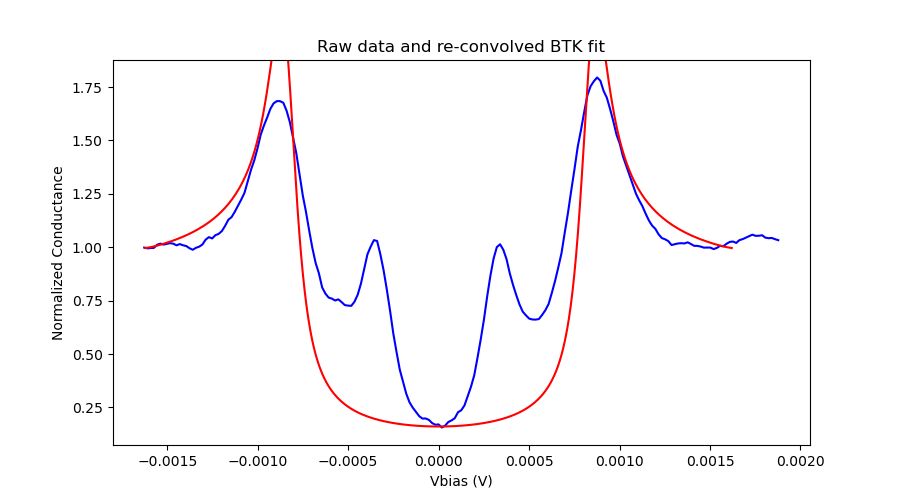

In [2]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
from scipy import optimize, signal, interpolate
import cmath, math, os
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, BoundedFloatText
from ipywidgets import Button, RadioButtons, Text

#file path
fdir = r"C:\algos\jupyter-notebooks\data\2021-02-17_8nm Nb_15nm Au_7nm Te_pt contact\3rd contact"
fname = "2021-02-17_3rdptcontact_dIdV_300mK_0T-2.4T inplane_15nm Au_7nm Te_unnormalized_25uVdV.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
ydata = data[:,1] #select the y-data
xdata = data[:,0] #select the x-data
dlen = len(xdata)

#define fitting parameters
kb = 8.617333262*10**(-5)
lower_pbound = (0.00001, 0, 0) #Lower bounds on fitting parameters (g, d, z)
upper_pbound = (.02, .01, 15) #Upper bounds on fitting parameters (g, d, z)
t = 4.2   #Temperature
norm_len = 5 #number of points to use for normalization
direct = 1 #use left or right side of data for normalization, +1 for left side, -1 for right side
xstep = 10**-5 #xdata point spacing for uniform xdata

#define fitting functions
def gamma(x, g, d):
    return (abs(x) + g*1j - cmath.sqrt((abs(x) + g*1j)**2 - d**2)) / d

#Gamma function below assumes complex gap instead of real and broadening is caused by this imaginary part of the gap
#def gamma(x, g, d):
    #return (abs(x) - cmath.sqrt((abs(x))**2 - (d - 1j*g)**2)) / (d - 1j*g)

def tau(z):
    return 1 / (1 + z**2)

def conductance(x, g, d, z):
    return (1 + tau(z) * abs(gamma(x, g, d))**2 + (tau(z) - 1) * abs(gamma(x, g, d)**2)**2) / (abs(1 + (tau(z) - 1)*gamma(x, g, d)**2))**2

def conductance_arr(xarr, g, d, z):
    return np.array([conductance(x, g, d, z) for x in xarr])

def dfermi(x, t):
    if (abs(x) < .007):
        try:
            return math.exp(abs(x) / (kb * t)) / (kb * t * (1 + math.exp(abs(x) / (kb * t)))**2)
        except OverflowError as err:
            raise OverflowError('too large, adjust input limits')
    else:
        return 0

def dfermi_peak(xdata, t):
    return np.array([dfermi(x, t) for x in xdata])

def normalize(data):
    return np.divide(data, np.average(data[direct : direct*norm_len: direct]))

#check if xdata is not monotonic
for x in range(dlen - 1):
    if(xdata[x] > xdata[x + 1]):
        print(x)

#normalize conductance and determine data step size
ydata = normalize(ydata)

#bspline fitting for a smooth version of the data
#bspline will only be defined on the domain specified by the xdata, if the x values go out of bounds the function returns NaN
knots, coeff, order = interpolate.splrep(xdata, ydata, s = .04, k = 3)
spline = interpolate.BSpline(knots, coeff, order, extrapolate = False)

#create uniformly spaced xdata for the spline fitting
xlimit = min(abs(xdata[0]), abs(xdata[dlen - 1]))
uxdata= np.linspace(-math.floor(xlimit / xstep) * xstep, math.floor(xlimit / xstep) * xstep, num = 2 * math.floor(xlimit / xstep) + 1)
uxlen = len(uxdata)
pad_size = math.floor(uxlen / 2)

#Fermi derivative peak and bspline based on uniform xdata
bspline_ydata = np.array(spline(uxdata))

#functions to convolve fermi function with ydata
def thermal_broaden(data, t):
    global uxdata
    global pad_size
    padded = np.pad(data, (pad_size, pad_size), mode = 'edge')
    con = np.convolve(padded, dfermi_peak(uxdata, t), mode = 'valid')
    return normalize(con)

def broad_conductance(xarr, g, d, z):
    return thermal_broaden(conductance_arr(xarr, g, d, z), t)

#try fitting the convolved BTK conductance to the bspline ydata
popt, pcov = optimize.curve_fit(broad_conductance, uxdata, bspline_ydata, bounds = (lower_pbound, upper_pbound), method = 'trf')
g = popt[0]
d = popt[1]
z = popt[2]
fit_ydata = np.array([conductance(x, g, d, z) for x in uxdata])

#Create plots
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(xdata, ydata, color = 'blue')
fit_plt, = ax.plot(uxdata, thermal_broaden(fit_ydata, t), color='red')
ax.set_ylabel('Normalized Conductance')
ax.set_xlabel('Vbias (V)')
ax.title.set_text('Raw data and re-convolved BTK fit')

# widget setup
out = Output()

width = {'width': '700px'}
temp = FloatText(value = .3, description = 'Temp')
gamma_param = FloatSlider(value=g, min=10**-6, max=10**-3, step=10**-6, description = r'$\Gamma$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
barrier = FloatSlider(value=z, min=0, max=5, step=0.01, description = r'$Z$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gap = FloatSlider(value=d, min=10**-4, max=2*10**-3, step=10**-5, description = r'$\Delta$', 
                         continuous_update = False, layout = width, readout_format = '.2e')

save = Button(description = 'Save')

save_option = RadioButtons(options=('Fit', 'Raw'))

filetext = Text(value = 'C:/algos/jupyter-notebooks/data/',description = 'Filename', layout = width)


def update(temp, gamma_param, barrier, gap):
    global uxdata
    fit_plt.set_ydata(thermal_broaden(conductance_arr(uxdata, gamma_param, gap, barrier), temp))
    fig.canvas.draw_idle()
    
def buttonClick(b):
    if(save_option.value is 'Fit'):
        np.savetxt(filetext.value, np.vstack((uxdata, np.array(fit_plt.get_ydata()))).T, delimiter = '\t', fmt = '%.4e')
    else:
         np.savetxt(filetext.value, np.vstack((xdata, ydata)).T, delimiter = '\t', fmt = '%.4e')
    
save.on_click(buttonClick)

it = interactive(update, temp = temp, gamma_param = gamma_param, barrier = barrier, gap = gap)

box_layout = Layout(display = 'flex', justify_content = 'flex-start', flex_flow = 'column',
                    align_items = 'flex-start', align_content = 'flex-start')

hbox = HBox(children = (save, save_option))

vbox = VBox(children = (temp, gamma_param, barrier, gap, out, filetext, hbox), layout = box_layout)

display(vbox)

# Double BTK Fitting

<IPython.core.display.Javascript object>


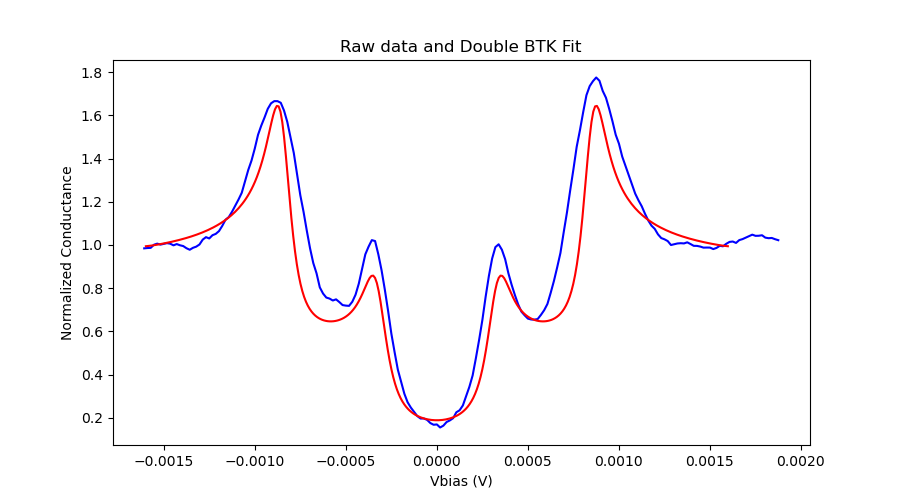

In [3]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
from scipy import optimize, signal, interpolate
import cmath, math, os
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, Button, Text
from ipywidgets import RadioButtons

#file path
fdir = r"C:\algos\jupyter-notebooks\data\2021-02-17_8nm Nb_15nm Au_7nm Te_pt contact\3rd contact"
fname = "2021-02-17_3rdptcontact_dIdV_300mK_0T-2.4T inplane_15nm Au_7nm Te_unnormalized_25uVdV.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float, skip_header = 1)
ydata = data[:,1] #select the y-data
xdata = data[:,0] #select the x-data
dlen = len(xdata)

# Scale/offset xdata
#xdata = xdata/1000
#xdata += .000084

#define fitting parameters
kb = 8.617333262*10**(-5)
lower_pbound = (0.00001, 0, 0) #Lower bounds on fitting parameters (g, d, z)
upper_pbound = (.02, .01, 15) #Upper bounds on fitting parameters (g, d, z)
t = 1   #Temperature
norm_len = 10 #number of points to use for normalization
direct = 1 #use left or right side of data for normalization, +1 for left side, -1 for right side
xstep = 10**-5 #xdata point spacing for uniform xdata

#define fitting functions
def gamma(x, g, d):
    return (abs(x) + g*1j - cmath.sqrt((abs(x) + g*1j)**2 - d**2)) / d

#Gamma function below assumes complex gap instead of real and broadening is caused by this imaginary part of the gap
#def gamma(x, g, d):
    #return (abs(x) - cmath.sqrt((abs(x))**2 - (d - 1j*g)**2)) / (d - 1j*g)

def tau(z):
    return 1 / (1 + z**2)

def conductance(x, g, d, z):
    return (1 + tau(z) * abs(gamma(x, g, d))**2 + (tau(z) - 1) * abs(gamma(x, g, d)**2)**2) / (abs(1 + (tau(z) - 1)*gamma(x, g, d)**2))**2

def conductance_arr(xarr, g, d, z):
    return np.array([conductance(x, g, d, z) for x in xarr])

def dfermi(x, t):
    if (abs(x) < .007):
        try:
            return math.exp(abs(x) / (kb * t)) / (kb * t * (1 + math.exp(abs(x) / (kb * t)))**2)
        except OverflowError as err:
            raise OverflowError('too large, adjust input limits')
    else:
        return 0

def dfermi_peak(xdata, t):
    return np.array([dfermi(x, t) for x in xdata])

def normalize(data):
    return np.divide(data, np.average(data[direct : direct*norm_len: direct]))

#normalize conductance and determine data step size
ydata = normalize(ydata)

#create uniformly spaced xdata for the spline fitting
xlimit = min(abs(xdata[0]), abs(xdata[dlen - 1]))
uxdata= np.linspace(-math.floor(xlimit / xstep) * xstep, math.floor(xlimit / xstep) * xstep, num = 2 * math.floor(xlimit / xstep) + 1)
uxlen = len(uxdata)
pad_size = math.floor(uxlen / 2)

#Fermi derivative peak

#functions to convolve fermi function with ydata
def thermal_broaden(data, t):
    global uxdata
    global pad_size
    padded = np.pad(data, (pad_size, pad_size), mode = 'edge')
    con = np.convolve(padded, dfermi_peak(uxdata, t), mode = 'valid')
    return normalize(con)

def broad_conductance(xarr, g, d, z):
    return thermal_broaden(conductance_arr(xarr, g, d, z), t)

# Default fitting

initial = thermal_broaden(0.5 * conductance_arr(uxdata, .0001, .001, 1) + 0.5 * conductance_arr(uxdata, .0001, .0005, 1), 0.3)

#Create plots
fig, ax = plt.subplots(figsize=(9,5))
origin, = ax.plot(xdata, ydata, color = 'blue')
fit_plt, = ax.plot(uxdata, initial, color='red')
ax.set_ylabel('Normalized Conductance')
ax.set_xlabel('Vbias (V)')
ax.title.set_text('Raw data and Double BTK Fit')

# widget setup
out = Output()

width = {'width': '700px'}
temp = FloatText(value = t, description = 'Temp')
gamma_param1 = FloatText(value = .0001, description = r'$\Gamma 1$')
barrier1 = FloatSlider(value=1, min=0.1, max=10, step=0.01, description = r'$Z1$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gap1 = FloatSlider(value=.001, min=10**-4, max=2*10**-3, step=10**-5, description = r'$\Delta 1$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gamma_param2 = FloatText(value = .0001, description = r'$\Gamma 2$')
barrier2 = FloatSlider(value=1, min=0.1, max=10, step=0.01, description = r'$Z2$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gap2 = FloatSlider(value=.0005, min=10**-4, max=2*10**-3, step=10**-5, description = r'$\Delta 2$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
weight = FloatSlider(value=0.5, min=0, max=1, step=.01, description = 'Weight', 
                         continuous_update = False, layout = width)

filetext = Text(value = 'C:/algos/jupyter-notebooks/data/',description = 'Filename', layout = width)

save = Button(description = 'Save')

save_option = RadioButtons(options=('Fit', 'Raw'))


def update(temp, gamma_param1, barrier1, gap1, gamma_param2, barrier2, gap2, weight):
    global uxdata
    fit_plt.set_ydata(thermal_broaden(weight*conductance_arr(uxdata, gamma_param1, gap1, barrier1) + (1-weight)*conductance_arr(uxdata, gamma_param2, gap2, barrier2), temp))
    fig.canvas.draw_idle()
    
def buttonClick(b):
    if(save_option.value is 'Fit'):
        np.savetxt(filetext.value, np.vstack((uxdata, np.array(fit_plt.get_ydata()))).T, delimiter = '\t', fmt = '%.4e')
    else:
         np.savetxt(filetext.value, np.vstack((xdata, ydata)).T, delimiter = '\t', fmt = '%.4e')
    
save.on_click(buttonClick)

it = interactive(update, temp = temp, gamma_param1 = gamma_param1, barrier1 = barrier1, gap1 = gap1,
                gamma_param2 = gamma_param2, barrier2 = barrier2, gap2 = gap2, weight = weight)

box_layout = Layout(display = 'flex', justify_content = 'flex-start', flex_flow = 'column',
                    align_items = 'flex-start', align_content = 'flex-start')

hbox = HBox(children = (save, save_option))

vbox = VBox(children = (temp, gamma_param1, barrier1, gap1, gamma_param2, barrier2, gap2, weight, filetext, hbox), layout = box_layout)

display(vbox)

# Fermi Liquid Effects in high field tunneling

[paper here](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.31.5811)

Weak coupling theory in superconductors involves several small expansion parameters:

1. Tc / $\theta_{debye}$
2. 1 / $k_f l$ = disorder parameter
3. 1 / $k_f \xi_0$
4. N(0)V, N(0) = DOS in normal state, V = interaction potential strength

Weak coupling theory is exact to 1st order in these parameters. Including these parameters to higher order results in different theories used to explain different effects:

1. Corrections to Tc / $\theta_{debye}$ are called strong-coupling effects
2. Corrections to 1 / $k_f l$ describe weak localization effects
3. Corrections to 1 / $k_f \xi_0$ are found in superfluid He3

Weak-coupling theory often ignores 3 additional effects:

1. Fermi-liquid effects - This renormalizes and adjusts certain parameters like density of states, Fermi velocities, mass, etc. 
2. Anisotropy effects - The fact that the Fermi surface is not a sphere and not isotropic. 
3. Impurity scattering

Some background information regarding Fermi liquid effects and theory:
The theory starts with a non-interacting Hamiltonian and turning on the interaction slowly in an adiabatic way. By doing it this way, Landau argues that the excited states of the original non-interacting case will smoothly transform into the excited states of the interacting system. This implies a bijection between the states of the non-interacting case and the interacting case. 

However, the excited states that are given by this bijection are not true eigenstates of the interacting Hamiltonian and, as such, they are not stationary. Therefore, there is a life-time associated with these excitations. These excitation in turn are called quasi-particles. They are called this way because the original particles, of the non-interacting system, become 'dressed' by the interactions so that certain dynamic properties of the particles, such as mass, are renormalized to new values. 

The act of turning on the interaction involves working with a time scale $\tau$ that must be bounded between two values. First, it must smaller than the energy scaled of interest $\epsilon$ so $\epsilon > \hbar / \tau$ or $\tau > \hbar / \epsilon$. Second, it must be smaller than the life-time of the quasi-particle otherwise the quasi-particle will disappear. 


Since we assume dirty limit, we take $l / \xi_0 \approx l / (\hbar v_f / k_b T_c) << 1$ with $l$ being the mean free path and $\xi_0$ being the coherence length. 

# Rainbow Plot

61


<IPython.core.display.Javascript object>


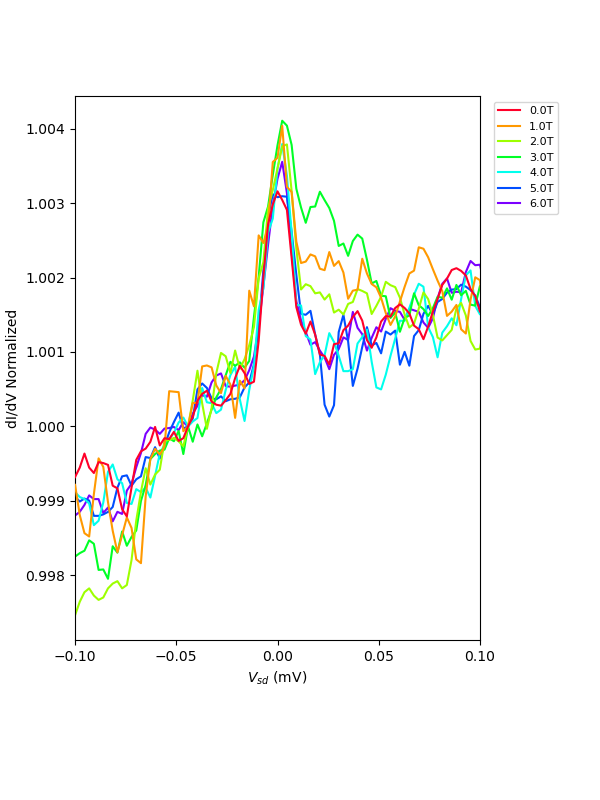

In [65]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmath, math, os
from scipy import optimize, signal, interpolate
from matplotlib.ticker import FormatStrFormatter

#single file path
fdir = r"C:\algos\jupyter-notebooks\data\2022-02-15_EuS"
fname = "2022-02-15_dIdV_vary H persis uniform_0.00T - 6.00T_101 steps_5E-6 Iscale_2.906E-4 Vscale_1 scans_sample1dev3_1nmTe_2.1uVdV_300mK_inplane.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

data = np.genfromtxt(fpath, delimiter="\t", dtype=float)

#data = data[:, 1:]

dV = 2.1 * 10**-6
step_size = 0
norm =  1 / (dV * 7.7480917*10**-5)
num_plots = int(data.shape[1] / 2)
print(num_plots)

params = np.linspace(0, 6, num = 61)

plots_to_plot = [0, 10, 20, 30, 40, 50, 60]

plot_cm = plt.cm.gist_rainbow(np.linspace(0, 1, len(plots_to_plot) + 1))

plt.figure(figsize = (6,8))

for c, i in enumerate(plots_to_plot):
    plt.plot(data[:, i*2]*1000, data[:, i*2 + 1] / (data[30, i*2 + 1])  + step_size*i, 
             color = plot_cm[c], zorder = 100 - 5*i)



#plt.yticks([0, .3])
#plt.yscale('log')
ax = plt.gca()
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.2f"))
#plt.ylabel(r'dI/dV ($2e^2/h$)')
plt.ylabel('dI/dV Normalized')

plt.xticks([-.1, -.05,  0, .05, .1])
plt.xlim([-.1, .1])
plt.xlabel(r'$V_{sd}$ (mV)')

#plt.ylim([.998, 1.005])

plt.gcf().subplots_adjust(bottom=0.2, right = 0.8)

legend_labels = ['{:.1f}T'.format(param) for param in map(params.__getitem__, plots_to_plot)]
#legend_labels = ['{:.3f}T'.format(param) for param in np.take(params, slices)]
#legend_labels = ['300mK, 0T', '300mK, 1T', '2K, 0T']
plt.legend(legend_labels, ncol = 1, prop={'size': 8, 'stretch': 'semi-expanded'},
           bbox_to_anchor = (1.02, 1), loc = 'upper left')

plt.show()

plt.savefig('./plt_img/2022-02-15_EuS_dIdV_300mK_0T-6T_focus_normalized_rainbow.png', transparent = True, dpi = 200)

# Theory Curve Plotting

<IPython.core.display.Javascript object>


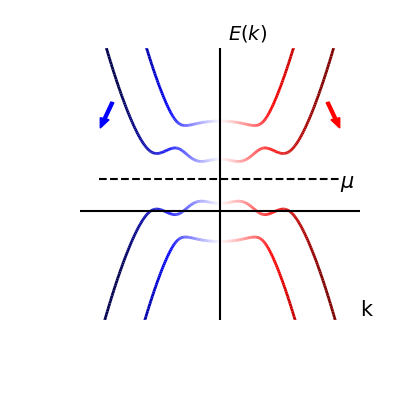

In [16]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
from scipy import optimize, signal, interpolate
import cmath, math, os

t = 1
u = 1*t
b = 0.7
d = 1


def band(x, sign):
    return math.sqrt(b**2 + d**2 + (x**2 - u)**2 + (u*x)**2 + 
                     2*sign * math.sqrt(b**2*d**2 + b**2 * (x**2 - u)**2 + (u*x)**2*(x**2-u)**2))

'''
def band(x, sign):
    return x**2 - u + sign*math.sqrt(4*x**2 + b**2)
'''

xdata = np.linspace(-math.pi, math.pi, num = 301)
ydata = np.array([band(x, 1) for x in xdata])
ydata2 = np.array([band(x, -1) for x in xdata])
ydata3 = u - ydata
ydata4 = u - ydata2

ydata_pts = np.array([xdata, ydata +1.2]).T.reshape(-1, 1, 2)
ydata_segments = np.concatenate([ydata_pts[:-1], ydata_pts[1:]], axis = 1)

norm = plt.Normalize(-math.pi+.5, math.pi-.5)
lc= LineCollection(ydata_segments, cmap = 'seismic', norm = norm)
lc.set_array(xdata)
lc.set_linewidth(2)


ydata_pts2 = np.array([xdata, ydata2 +1.2]).T.reshape(-1, 1, 2)
ydata_segments2 = np.concatenate([ydata_pts2[:-1], ydata_pts2[1:]], axis = 1)

lc2= LineCollection(ydata_segments2, cmap = 'seismic', norm = norm)
lc2.set_array(xdata)
lc2.set_linewidth(2)

ydata_pts3 = np.array([xdata, ydata3]).T.reshape(-1, 1, 2)
ydata_segments3 = np.concatenate([ydata_pts3[:-1], ydata_pts3[1:]], axis = 1)

lc3= LineCollection(ydata_segments3, cmap = 'seismic', norm = norm)
lc3.set_array(xdata)
lc3.set_linewidth(2)


ydata_pts4 = np.array([xdata, ydata4]).T.reshape(-1, 1, 2)
ydata_segments4 = np.concatenate([ydata_pts4[:-1], ydata_pts4[1:]], axis = 1)

lc4= LineCollection(ydata_segments4, cmap = 'seismic', norm = norm)
lc4.set_array(xdata)
lc4.set_linewidth(2)


fig, ax = plt.subplots(figsize = (4,4))
plt.subplots_adjust(hspace = 0, bottom = 0.2, left = 0.2)

line1 = ax.add_collection(lc)
line2 = ax.add_collection(lc2)
line3 = ax.add_collection(lc3)
line4 = ax.add_collection(lc4)

ax.plot([-math.pi, math.pi], [1.2, 1.2],color = 'black',linestyle = '--')

#curve1 = ax.plot(xdata, ydata + 2.2, color = 'blue')
#curve2 = ax.plot(xdata, ydata2 + 2.2, color = 'red')
#curv2 = ax.plot([.25, .25], [0, 1.2], color = 'red', linestyle = '--')
#curv3 = ax.plot(xdata, ydata2, color = 'green')

#ax.scatter(m, alpha*m**2 + beta / 2 *m**4, color = 'red')
#ax.scatter(-m, alpha*m**2 + beta / 2 *m**4, color = 'red')

ax.tick_params(axis = 'both', which = 'both', bottom = False, left = False, labelleft = False, labelbottom = False)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.set_xlabel(r'$E$', fontsize = 20, labelpad = 0)
#ax.xaxis.set_label_coords(1, -.05)
#ax.set_ylabel(r'$D_s(E)$', fontsize = 15, rotation = 0, labelpad = 25)
ax.set_ylim([-4, 6])
ax.set_xlim([-math.pi - .5, math.pi +.5])
#ax.set_xticks([-math.pi, 0, math.pi])
#ax.set_xticklabels([r'$\Delta$'], fontsize = 15)
#ax.set_yticks([0, .5, 1])
fig.text(0.57, .9,'$E(k)$', fontsize = 14)
fig.text(0.9, .21, 'k', fontsize = 15)

fig.text(0.85, .53, r'$\mu$', fontsize = 15)

plt.arrow(2.8, 4, .2, -.6, width = 0.08, color = 'red')

plt.arrow(-2.8, 4, -.2, -.6, width = 0.08, color = 'blue')

plt.show()

#plt.savefig('./plt_img/spinorbitbandszeemansc2.png', transparent = True, dpi = 200)

# Multiple File Plotting

<IPython.core.display.Javascript object>


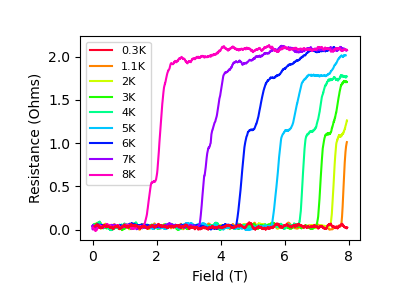

In [21]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math, glob, os

#directory
data_dir = "C:/algos/jupyter-notebooks/data/2021-04-23_12nm Nb_5nm Au_10nm Te_pt contact/Transport_inplane field"

#load data
data = []
os.chdir(data_dir)
files = glob.glob('*[0-9]K.txt')

for file in files:
    data.append(np.genfromtxt(file, delimiter="\t", dtype=float))

num_plots = len(data)


#build rainbow cmap for legend
plot_cm = plt.cm.gist_rainbow(np.linspace(0, 1, num_plots))

fig, ax = plt.subplots(figsize=(4, 3))
plt.subplots_adjust(left = 0.2 ,bottom = 0.2)   

for i in range(num_plots):
    zorder = i
    if i is 0:
        zorder = 20
    ax.plot(data[i][:, 0], data[i][:, 1], color = plot_cm[i], zorder = zorder)

ax.set_xlabel('Field (T)')
ax.set_ylabel('Resistance (Ohms)')
ax.legend(['0.3K','1.1K', '2K', '3K', '4K', '5K', '6K', '7K', '8K'], prop={'size': 8})

plt.show()

#save img
os.chdir('C:/algos/jupyter-notebooks')
plt.savefig('./plt_img/2021-04-23_RvsH_12nm Nb_5nm Au_300mK-8K.png')

# H - T Pauli Limit Fit

[3.05508357]


<IPython.core.display.Javascript object>


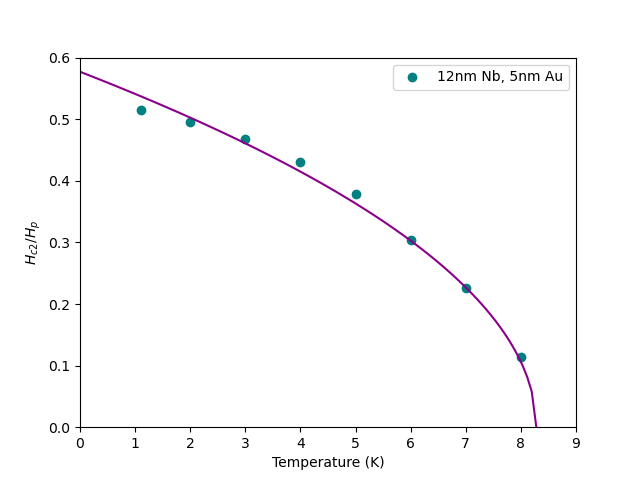

In [9]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math

#file path
fpath = "C:/Users/cliff_chen/Downloads/2021-04-23_transport/2021-04-23_RvsH_H-T diagram.txt"

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
fields = data[:, 1]
temps = data[:, 0]

#pair breaker function
def get_pair_breaker(tc0):
    return lambda arr, a: np.array([a*math.sqrt(tc0 - x) for x in arr])

#zero field transition temp
tc0 = 8.28
pauli_limit = 1.84*tc0

#fit the data
pair_break = get_pair_breaker(tc0)
amplitude = optimize.curve_fit(pair_break, temps, fields, (1))[0]
print(amplitude)

#plot the data
lin_temps = np.linspace(0, tc0, 101)

fig, ax = plt.subplots()
ax.scatter(temps, fields / pauli_limit, c = 'teal', label = '12nm Nb, 5nm Au')
ax.plot(lin_temps, [amplitude*math.sqrt(tc0 - x) / pauli_limit for x in lin_temps], color = 'darkmagenta')
ax.set_ylim((0, 0.6))
ax.set_xlim((0, math.ceil(tc0)))
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$H_{c2} / H_p$')
#ax.legend()
plt.show()

#plt.savefig('./img/2021-04-23_H-T diagram_RvsH.png')

# General Plotting

up_negfield 0.354440624, 0.16821575, 0.957918634043599
up_posfield 0.329312176, -0.116423594, 0.975577036299678
down_negfield -0.34739965600000006, -0.10942696000000002, -0.9679568506783699
down_posfield -0.384997556, 0.15678197, -0.969864451215548


<IPython.core.display.Javascript object>


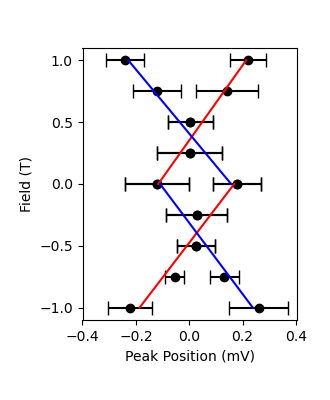

In [61]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate, stats
import cmath, math, os

#file path
fdir = r"C:\algos\jupyter-notebooks\data\2021-04-23_12nm Nb_5nm Au_10nm Te_pt contact"
fname = "Andreev Peak Gaussian Fit_upspin.txt"
fname2 = "Andreev Peak Gaussian Fit_downspin.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)
fpath2 = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname2)

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
data2 = np.genfromtxt(fpath2, delimiter="\t", dtype=float)

#up spin and down spin data sets
up_negfield_x = data[0:5, 0]
up_posfield_x = data[5:, 0]
down_negfield_x = data2[0:5, 0]
down_posfield_x = data2[5:, 0]

up_negfield_y = data[0:5, 1]
up_posfield_y = data[5:, 1]
down_negfield_y = data2[0:5, 1]
down_posfield_y = data2[5:, 1]

up_negfield_err = data[0:5, 3]
up_posfield_err = data[5:, 3]
down_negfield_err = data2[0:5, 3]
down_posfield_err = data2[5:, 3]


#generate fit
res_up_negfield = stats.linregress(up_negfield_x, up_negfield_y)
res_up_posfield = stats.linregress(up_posfield_x, up_posfield_y)
res_down_negfield = stats.linregress(down_negfield_x, down_negfield_y)
res_down_posfield = stats.linregress(down_posfield_x, down_posfield_y)

print('up_negfield {}, {}, {}'.format(res_up_negfield.slope, res_up_negfield.intercept, res_up_negfield.rvalue))
print('up_posfield {}, {}, {}'.format(res_up_posfield.slope, res_up_posfield.intercept, res_up_posfield.rvalue))
print('down_negfield {}, {}, {}'.format(res_down_negfield.slope, res_down_negfield.intercept, res_down_negfield.rvalue))
print('down_posfield {}, {}, {}'.format(res_down_posfield.slope, res_down_posfield.intercept, res_down_posfield.rvalue))

fig, ax = plt.subplots(figsize = (3.3, 4))

ax.scatter(up_negfield_y, up_negfield_x, color = 'black')
ax.errorbar(up_negfield_y, up_negfield_x, xerr = up_negfield_err/math.sqrt(2), fmt = 'none',capsize = 5, color = 'black')
ax.plot(res_up_negfield.slope*up_negfield_x + res_up_negfield.intercept, up_negfield_x,  color = 'red', linestyle = '-')

ax.scatter(up_posfield_y, up_posfield_x, color = 'black')
ax.errorbar(up_posfield_y, up_posfield_x, xerr = up_posfield_err/math.sqrt(2), fmt = 'none',capsize = 5, color = 'black')
ax.plot( res_up_posfield.slope*up_posfield_x + res_up_posfield.intercept, up_posfield_x, color = 'red', linestyle = '-')

ax.scatter(down_negfield_y, down_negfield_x, color = 'black')
ax.errorbar(down_negfield_y, down_negfield_x, xerr = down_negfield_err/math.sqrt(2), fmt = 'none',capsize = 5, color = 'black')
ax.plot(res_down_negfield.slope*down_negfield_x + res_down_negfield.intercept, down_negfield_x, color = 'blue', linestyle = '-')

ax.scatter(down_posfield_y, down_posfield_x, color = 'black')
ax.errorbar(down_posfield_y, down_posfield_x, xerr = down_posfield_err/math.sqrt(2), fmt = 'none',capsize = 5, color = 'black')
ax.plot(res_down_posfield.slope*down_posfield_x + res_down_posfield.intercept, down_posfield_x, color = 'blue', linestyle = '-')

ax.set_ylabel('Field (T)')
ax.set_xlabel('Peak Position (mV)')
ax.set_yticks([-1, -.5, 0, .5, 1])
ax.set_xticks([-.4, -0.2, 0, 0.2, .4])

plt.subplots_adjust(hspace = 0, left = 0.25, bottom = .2) 
#fig.text(0.02, 0.5, 'Peak Position (mV)', va='center', rotation='vertical')

plt.show()

plt.savefig('./plt_img/2021-04-23_dIdV ptcontact_5nmAu_12nm Nb_inplane_peakpositions_bothfields_vertical.png', transparent = True)

# dI/dV Heat / Intensity Map Plotting

Num data pts = 197, Num Plots = 17


<IPython.core.display.Javascript object>


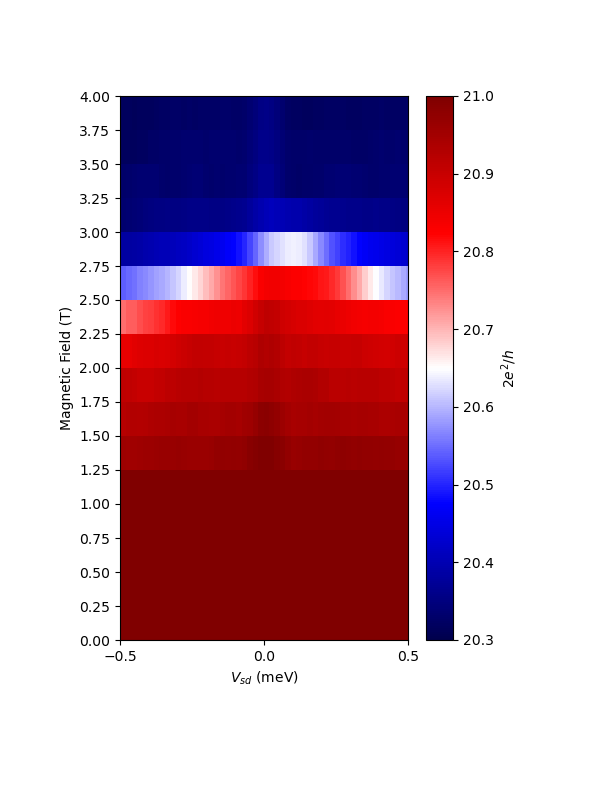

In [6]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math, os

#file path
fdir = r"C:\algos\jupyter-notebooks\data\2022-02-15_EuS"
fname = "2022-02-15_sample1_dev3_dIdV_0T-4T_inplanefield_300mk_9.6uVdV.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

data = np.genfromtxt(fpath, delimiter="\t", dtype=float)

#since individual plots may be offset along x-axis from each other, find a common x-interval to use for heat map
xlimits = (-.0015, .0015)
xscale = 1000 #to multiply the x-coordinates
yscale = 1 #to multiply the y-coordinates
dV = 9.6*10**-6
quantum_norm = True
single_x = False
zmin = 20.3
zmax = 21

print('Num data pts = {0}, Num Plots = {1}'.format(data.shape[0], data.shape[1] // 2 if not single_x else data.shape[1] - 1))

# choose parameter interval to plot
p_start = 0
p_end = 17
params = np.linspace(0, 4, num = 17)

# include colorbar
yes_cbar = True

num_plots = data.shape[1] // 2 if not single_x else data.shape[1] - 1
x = []
z = []

if not single_x:
    for i in range(num_plots):
        z.append(data[np.nonzero(np.logical_and(data[:,i*2] >= xlimits[0], data[:,i*2] <= xlimits[1])), i*2+1])
        x.append(data[np.nonzero(np.logical_and(data[:,i*2] >= xlimits[0], data[:,i*2] <= xlimits[1])), i*2])
    
    z = np.concatenate(z)
    x = xscale * np.concatenate(x)
else:
    for i in range(data.shape[1] - 1):
        z.append(data[:, i + 1])
        x.append(data[:, 0])
    
    z = np.vstack(z)
    x = xscale * np.vstack(x)
    
#repeat param_values array and then reshape to get the Y-coord grid, similar to what one would get from meshgrid
y = np.repeat(params, x.shape[1], axis = 0)
y = yscale * np.reshape(y, (len(params), x.shape[1]))

#normalize data
if quantum_norm:
    z = z / (dV * 7.7480917*10**-5)
else:
    for i in range(num_plots):
        z[i, :] *= 1 / np.average(data[0:5, i*2 + 1 if not single_x else i + 1])


fig, ax = plt.subplots(figsize = (6, 8))
pmesh = ax.pcolormesh(x[p_start : p_end, :],
                      y[p_start : p_end, :],
                      z[p_start : p_end, :],
                      vmin = zmin, vmax = zmax, shading = 'auto', cmap = plt.get_cmap('seismic'))

ax.set_xlabel(r'$V_{sd}$ (meV)')
ax.set_ylabel('Magnetic Field (T)')

if yes_cbar:
    cbar = plt.colorbar(pmesh, orientation = 'vertical')

    if quantum_norm:
        cbar.set_label(r'$2e^2/h$')
    else:
        cbar.set_label('Normalized Conductance')

ax.set_xticks(np.linspace(-1.5, 1.5, num = 7))
ax.set_xlim([-.5, .5])
ax.set_yticks(np.linspace(0, 4, num = 17))
        
plt.subplots_adjust(left = 0.2 ,bottom = 0.2, right = 0.8)    
plt.show()

#plt.savefig('./plt_img/2022-02-15_EuS_dIdV_300mK_0T-4T_heatmap.png', transparent = True)

# dI/dV Heat Map with Slice Plots on the side

Num data pts = 201, Num Plots = 31
Slices taken at following parameters:
[6.1  6.   0.01 0.  ]


<IPython.core.display.Javascript object>


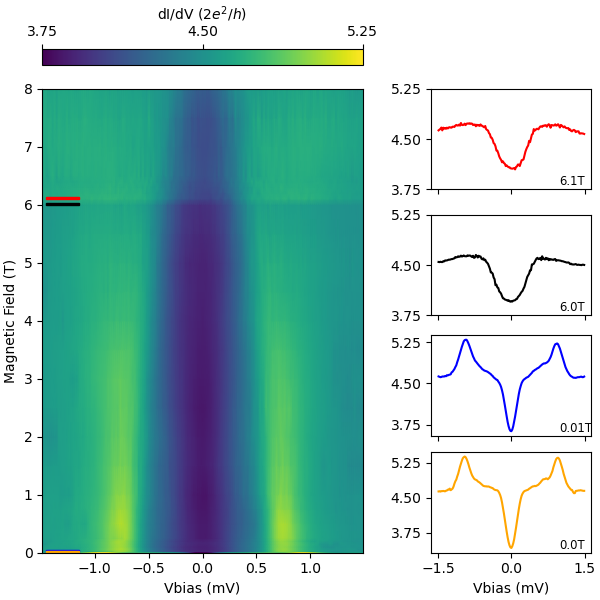

In [20]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from scipy import optimize, signal, interpolate
import cmath, math, os

#file path
fdir = r"C:\algos\jupyter-notebooks\data\2022-01-06_4nmNb_2nmAu_500nmwire device_150nm Al leads_6angTebarrier"
fname = "2022-01-06_dIdV_4nm Nb_2nmAu_300mK_0T-8T inplane field_150nm Al leads_9.6uVdV_J1 tunnel.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
print('Num data pts = {0}, Num Plots = {1}'.format(data.shape[0], data.shape[1] // 2))

# since individual plots may be offset along x-axis from each other, find a common x-interval to use for heat map
# this assumes that all plots have equal spacing between points
xlimits = (-.0015, .0015)

# data settings
xscale = 1000 #to multiply the x-coordinates
yscale = 1 #to multiply the y-coordinates
z_min = 3.75
z_max =5.25
dV = 9.6*10**-6
quantum_norm = True
single_x = False

# slice plot indices and info
slices = [23, 22, 1, 0]
slice_units = 'T'
slice_colors = ['red', 'black', 'blue', 'orange']
slice_xticks = np.linspace(-1.5, 1.5, num = 3)
slice_yticks = np.linspace(3.75, 5.25, num = 3)

# list of the varying parameters for each scan
params = np.array([
    0,
0.01,
0.02,
0.03,
0.04,
0.05,
0.1,
0.15,
0.2,
0.25,
0.5,
0.75,
1,
1.5,
2,
2.5,
3,
3.5,
4,
4.5,
5,
5.5,
6,
6.1,
6.2,
6.3,
6.4,
6.5,
7,
7.5,
8
])

# indicate which slices are used
print('Slices taken at following parameters:')
print(params[slices])

num_plots = data.shape[1] // 2 if not single_x else data.shape[1] - 1
x = []
z = []

if not single_x:
    for i in range(num_plots):
        z.append(data[np.nonzero(np.logical_and(data[:,i*2] >= xlimits[0], data[:,i*2] <= xlimits[1])), i*2+1])
        x.append(data[np.nonzero(np.logical_and(data[:,i*2] >= xlimits[0], data[:,i*2] <= xlimits[1])), i*2])
    
    z = np.concatenate(z)
    x = xscale * np.concatenate(x)
else:
    for i in range(data.shape[1] - 1):
        z.append(data[:, i + 1])
        x.append(data[:, 0])
    
    z = np.vstack(z)
    x = xscale * np.vstack(x)

#repeat param_values array and then reshape to get the Y-coord grid, similar to what one would get from meshgrid
y = np.repeat(params, x.shape[1], axis = 0)
y = yscale * np.reshape(y, (len(params), x.shape[1]))

#normalize data
if quantum_norm:
    z = z / (dV * 7.7480917*10**-5)
else:
    for i in range(num_plots):
        z[i, :] *= 1 / np.average(data[0:5, i*2 + 1 if not single_x else i + 1])

fig = plt.figure(figsize = (6, 6), dpi = 100, constrained_layout = True)
gs = fig.add_gridspec(len(slices), 3)
heat_ax = fig.add_subplot(gs[:, 0:2])
slice_axes = [fig.add_subplot(gs[i, 2]) for i in range(len(slices))]

# plot the colormesh
pmesh = heat_ax.pcolormesh(x,y,z, vmin = z_min, vmax = z_max, shading = 'gouraud', cmap = plt.get_cmap('viridis'))
heat_ax.set_xlabel('Vbias (mV)')
heat_ax.set_ylabel('Magnetic Field (T)')

cbar = plt.colorbar(pmesh, ax = heat_ax, location = 'top')
cbar.set_ticks(np.linspace(z_min, z_max, num = 3))

if quantum_norm:
    cbar.set_label(label = r'dI/dV ($2e^2/h$)')
else:
    cbar.set_label('Normalized dI/dV')
    
# plot the slice plots
for i, ax in enumerate(slice_axes):
    # plot the slice curve
    ax.plot(x[slices[i], :], z[slices[i], :], color = slice_colors[i])
    
    # add parameter text to each slice plot
    ax.text(x = .8, y = .01, s = str(params[slices[i]]) + slice_units, 
            verticalalignment = 'bottom', transform = ax.transAxes, fontsize = 'small')
    
    # add colored indicator on pcolormesh to indicate where slice is being taken
    heat_ax.add_patch(Rectangle((xscale*xlimits[0]+.05 if not single_x else x[0][0], params[slices[i]]), 
                           .3, .03, color = slice_colors[i]))
    
    # remove any tick labels from the graphs not at the bottom
    if i is not len(slice_axes) - 1:
        ax.tick_params(labelbottom = False)
    
# set the slice plot x and y ticks
for ax in slice_axes:
    ax.set_xticks(slice_xticks)
    ax.set_yticks(slice_yticks)
    
# set the x label on the bottom slice plot
slice_axes[-1].set_xlabel('Vbias (mV)')

plt.show()

#plt.savefig('./plt_img/2020-09-30_dIdV ptcontact_5nmAu_8nm Nb_outplane_quantumnormalized_slices.png')

# dI/dV Multiple File Stacked Plotting

Number of plots: 3
File0: 1.0 curves, 249 pts
File1: 1.0 curves, 1001 pts
File2: 1.0 curves, 395 pts
File3: 1.0 curves, 833 pts
File4: 1.0 curves, 1185 pts
File5: 1.0 curves, 201 pts


<IPython.core.display.Javascript object>


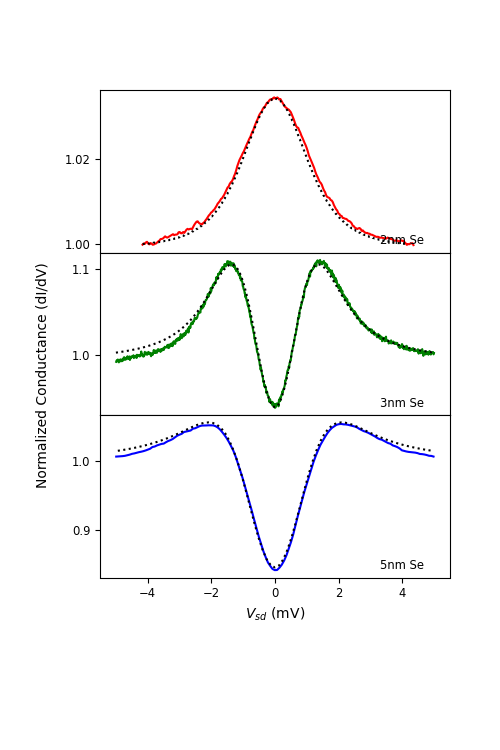

In [1]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy import optimize, signal, interpolate
import cmath, math, os

quantum_cond = 7.7480917 * 10**-5
norm_len = 5
xscale = 1000
interval = (-.005, .005)


files = [
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-07-29_ptcontact_14nm Au_9nm Nb_2nm Se_raw.txt',
        'num': 0,
        'singlex': False,
        'color': 'red',
        'norm': 'avg',
        'norm_dir': 'end', 
        'label': '2nm Se'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-05-14_dIdV_pt contact_3nm Au - 9nm Nb_3nm Se_4.2K_0 field.dat',
        'num': 0,
        'singlex': False,
        'color': 'green',
        'norm': 'avg',
        'norm_dir': 'end', 
        'label': '3nm Se'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-06-26_dIdV_pt contact_27nm Au - 9nm Nb_5nm Se_4.2K_0 field.dat',
        'num': 0,
        'singlex': False,
        'color': 'blue',
        'norm': 'avg',
        'norm_dir': 'end', 
        'label': '5nm Se'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-07-29_ptcontact_14nm Au_9nm Nb_2nm Se_fittingonly.txt',
        'num': 0,
        'singlex': False,
        'color': 'black',
        'norm': 'avg',
        'ax': 0,
        'linestyle': ':'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-05-14_dIdV_pt contact_3nm Au - 9nm Nb_3nm Se_4.2K_0 field_fittingonly.dat',
        'num': 0,
        'singlex': False,
        'color': 'black',
        'norm': 'avg',
        'ax': 1,
        'linestyle': ':'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-06-26_dIdV_pt contact_27nm Au - 9nm Nb_5nm Se_4.2K_0 field_fittingonly.dat',
        'num': 0,
        'singlex': False,
        'color': 'black',
        'norm': 'avg',
        'ax': 2,
        'linestyle': ':'
    }
]

datas = []
num_plots = 0

for file in files:
    fpath = os.path.join(os.path.normpath(file['dir'].replace('\\', '/')), file['name'])
    datas.append(np.genfromtxt(fpath, delimiter="\t", dtype=float))
    if('ax' not in file):
        num_plots += 1

print('Number of plots: ' + str(num_plots))
        
for i, data in enumerate(datas):
    print('File{}: {} curves, {} pts'.format(i, data.shape[1] - 1 if files[i]['singlex'] else data.shape[1] / 2, data.shape[0]))

fig, ax = plt.subplots(nrows = num_plots, ncols = 1, figsize = (5, 2.5*num_plots), sharex = True)

plt.subplots_adjust(hspace = 0, bottom = 0.23, left = 0.2)

for i, data in enumerate(datas):
    plot_num = files[i]['num']
    singlex = files[i]['singlex']
    label = '' if 'label' not in files[i] else files[i]['label']
    color = files[i]['color']
    ax_num = i if 'ax' not in files[i] else files[i]['ax']
    linestyle = '-' if 'linestyle' not in files[i] else files[i]['linestyle']
    
    try:
        norm = float(files[i]['norm'])
    except ValueError:
        if 'norm_dir' in files[i] and files[i]['norm_dir'] is 'end':
            norm = 1 / np.average(data[-1*norm_len :, plot_num + 1] if singlex else data[-1*norm_len :, plot_num*2 + 1])
        else:
            norm = 1 / np.average(data[0:norm_len, plot_num + 1] if singlex else data[0:norm_len, plot_num*2 + 1])
   
    xdata = data[:, 0] if singlex else data[:, plot_num * 2]
    ydata = data[:, plot_num + 1] if singlex else data[:, plot_num * 2 + 1]
    mask = np.nonzero(np.logical_and(xdata >= interval[0], xdata <= interval[1]))
    
    ax[ax_num].plot(xscale * xdata[mask], norm * ydata[mask], color = color, linestyle = linestyle)
    ax[ax_num].tick_params(axis = 'both', labelsize = 'small')
    ax[ax_num].locator_params(axis = 'x', nbins = 6)
    ax[ax_num].locator_params(axis = 'y', nbins = 3)
    ax[ax_num].text(x = 0.8, y = .05, s = label, fontsize = 'small', transform = ax[ax_num].transAxes)

fig.text(0.07, 0.5, 'Normalized Conductance (dI/dV)', va='center', rotation='vertical')
plt.xlabel(r'$V_{sd}$ (mV)')

# additional adjustments to plt
#plt.ylabel(r'dI/dV $(2e^2/h)$')
#plt.xlim((-2, 2))

plt.show()

#plt.savefig('./plt_img/dIdV_ptcontact_barrier comparison_Se barrier with fits.png', dpi = 200, transparent = True)

# dI/dV Multiple file stacked grid plotting

<IPython.core.display.Javascript object>


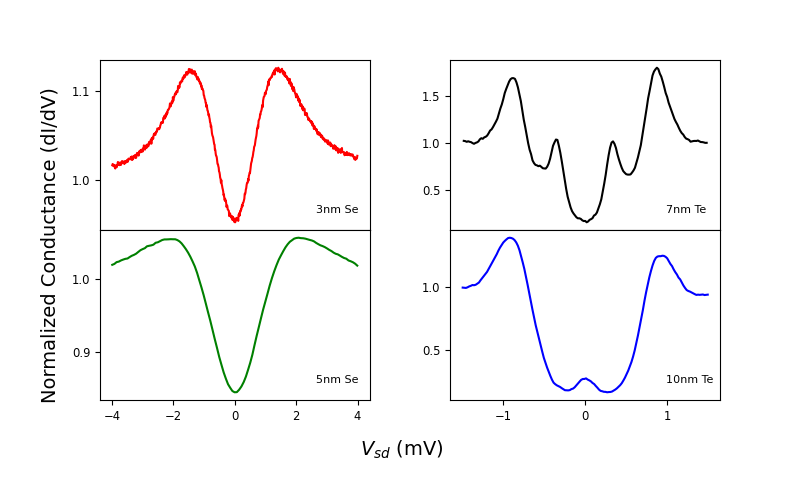

In [25]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy import optimize, signal, interpolate
import cmath, math, os

quantum_cond = 7.7480917 * 10**-5
plot_grid = (2, 2)
norm_len = 5
xscale = 1000
intervals = [(-.004, .004), (-.0015, .0015)]


files = [
    [{
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-05-14_dIdV_pt contact_3nm Au - 9nm Nb_3nm Se_4.2K_0 field.dat',
        'num': 0,
        'singlex': False,
        'color': 'red',
        'norm': 'avg',
        'label': '3nm Se'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-06-26_dIdV_pt contact_27nm Au - 9nm Nb_5nm Se_4.2K_0 field.dat',
        'num': 0,
        'singlex': False,
        'color': 'green',
        'norm': 'avg',
        'label': '5nm Se'
    }],
    # next column
    [{
        'dir': r'C:\algos\jupyter-notebooks\data\2021-02-17_8nm Nb_15nm Au_7nm Te_pt contact\3rd contact',
        'name': '2021-02-17_3rdptcontact_dIdV_300mK_0T-2.4T inplane_15nm Au_7nm Te_unnormalized_25uVdV.txt',
        'num': 0,
        'singlex': False,
        'color': 'black',
        'norm': 'avg',
        'label': '7nm Te'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\2021-04-23_12nm Nb_5nm Au_10nm Te_pt contact',
        'name': '2021-04-23_dIdV_vary H inplane persistent_-8T - 8T_0.25TdT_-1.7mV - 2.267mV_12nm Nb_5nmAu_300mK_smoothed_unnormalized_80uVdV.txt',
        'num': 33,
        'singlex': False,
        'color': 'blue',
        'norm': 'avg',
        'label': '10nm Te'
    }]
]

datas = []

for column in files:
    col = []
    for file in column:
        fpath = os.path.join(os.path.normpath(file['dir'].replace('\\', '/')), file['name'])
        col.append(np.genfromtxt(fpath, delimiter="\t", dtype=float))
    datas.append(col)

#for i, data in enumerate(datas):
#    print('File{}: {} plots, {} pts'.format(i, data.shape[1] - 1 if files[i]['singlex'] else data.shape[1] / 2, data.shape[0]))

fig, ax = plt.subplots(nrows = plot_grid[0], ncols = plot_grid[1],
                       figsize = (4*plot_grid[0], 2.5*plot_grid[1]), sharex = 'col')

# sharex = 'col' for column sharing

plt.subplots_adjust(bottom = 0.2)

for i, data_col in enumerate(datas):
    for j, data in enumerate(data_col):
        plot_num = files[i][j]['num']
        singlex = files[i][j]['singlex']
        label = files[i][j]['label']
        color = files[i][j]['color']
                       
        try:
            norm = float(files[i][j]['norm'])
        except ValueError:
            norm = 1 / np.average(data[0:norm_len, plot_num + 1] if singlex else data[0:norm_len, plot_num*2 + 1])

        xdata = data[:, 0] if singlex else data[:, plot_num * 2]
        ydata = data[:, plot_num + 1] if singlex else data[:, plot_num * 2 + 1]
        mask = np.nonzero(np.logical_and(xdata >= intervals[i][0], xdata <= intervals[i][1]))

        ax[j, i].plot(xscale * xdata[mask], norm * ydata[mask], color = color)
        ax[j, i].tick_params(axis = 'both', labelsize = 'small')
        ax[j, i].locator_params(axis = 'x', nbins = 6)
        ax[j, i].locator_params(axis = 'y', nbins = 3)
        ax[j, i].text(x = .8, y = .1, s = label, fontsize = 8, transform = ax[j, i].transAxes)

fig.text(0.05, 0.51, 'Normalized Conductance (dI/dV)', va='center', rotation='vertical', fontsize = 14)
fig.text(0.45, 0.1, r'$V_{sd}$ (mV)', va='center', rotation='horizontal', fontsize = 14)
#plt.xlabel(r'$V_{sd}$ (mV)')

plt.show()

plt.savefig('./plt_img/dIdV_ptcontact_barrier comparison.png', dpi = 200, transparent = True)

# dI/dV Multiple File Single Plot Stack

File0: 1.0 plots, 1001 pts
File1: 1.0 plots, 395 pts
File2: 11.0 plots, 197 pts
File3: 65.0 plots, 198 pts


<IPython.core.display.Javascript object>


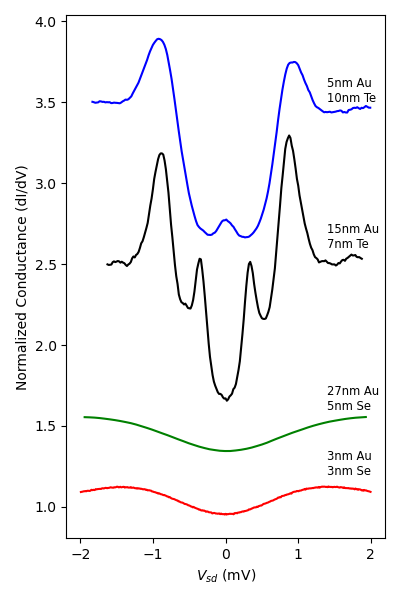

In [48]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy import optimize, signal, interpolate
import cmath, math, os

quantum_cond = 7.7480917 * 10**-5
norm_len = 5
xscale = 1000
interval = (-.002, .002)
yspacing = (0, .5, 1.5, 2.5)
label_spacing = (0, .4, 1.4, 2.3)


files = [
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-05-14_dIdV_pt contact_3nm Au - 9nm Nb_3nm Se_4.2K_0 field.dat',
        'num': 0,
        'singlex': False,
        'color': 'red',
        'norm': 'avg',
        'label': '3nm Au\n3nm Se'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-06-26_dIdV_pt contact_27nm Au - 9nm Nb_5nm Se_4.2K_0 field.dat',
        'num': 0,
        'singlex': False,
        'color': 'green',
        'norm': 'avg',
        'label': '27nm Au\n5nm Se'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\2021-02-17_8nm Nb_15nm Au_7nm Te_pt contact\3rd contact',
        'name': '2021-02-17_3rdptcontact_dIdV_300mK_0T-2.4T inplane_15nm Au_7nm Te_unnormalized_25uVdV.txt',
        'num': 0,
        'singlex': False,
        'color': 'black',
        'norm': 'avg',
        'label': '15nm Au\n7nm Te'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\2021-04-23_12nm Nb_5nm Au_10nm Te_pt contact',
        'name': '2021-04-23_dIdV_vary H inplane persistent_-8T - 8T_0.25TdT_-1.7mV - 2.267mV_12nm Nb_5nmAu_300mK_smoothed_unnormalized_80uVdV.txt',
        'num': 33,
        'singlex': False,
        'color': 'blue',
        'norm': 'avg',
        'label': '5nm Au\n10nm Te'
    }
]

datas = []

for file in files:
    fpath = os.path.join(os.path.normpath(file['dir'].replace('\\', '/')), file['name'])
    datas.append(np.genfromtxt(fpath, delimiter="\t", dtype=float))

for i, data in enumerate(datas):
    print('File{}: {} plots, {} pts'.format(i, data.shape[1] - 1 if files[i]['singlex'] else data.shape[1] / 2, data.shape[0]))

fig, ax = plt.subplots(figsize = (4, 1.5*len(datas)))

for i, data in enumerate(datas):
    plot_num = files[i]['num']
    singlex = files[i]['singlex']
    label = files[i]['label']
    color = files[i]['color']
    
    try:
        norm = float(files[i]['norm'])
    except ValueError:
        norm = 1 / np.average(data[0:norm_len, plot_num + 1] if singlex else data[0:norm_len, plot_num*2 + 1])
   
    xdata = data[:, 0] if singlex else data[:, plot_num * 2]
    ydata = data[:, plot_num + 1] if singlex else data[:, plot_num * 2 + 1]
    mask = np.nonzero(np.logical_and(xdata >= interval[0], xdata <= interval[1]))
    
    ax.plot(xscale * xdata[mask], norm * ydata[mask] + yspacing[i], color = color)
    #ax.tick_params(axis = 'both', labelsize = 'small')
    #ax.locator_params(axis = 'x', nbins = 6)
    #ax.locator_params(axis = 'y', nbins = 3)
    ax.text(x = .7*xscale*interval[1], y = 1.2 + label_spacing[i], s = label, fontsize = 'small')

ax.set_ylabel(r'Normalized Conductance (dI/dV)')
ax.set_xlabel(r'$V_{sd}$ (mV)')
fig.tight_layout()

plt.show()

#plt.savefig('./plt_img/dIdV_ptcontact_barrier comparison_singleplotstack.png', dpi = 200, transparent = True)

# dIdV Intensity Map Vertical Slice

Num data pts = 198, Num Plots = 65
X Coord = 0.00991547


<IPython.core.display.Javascript object>


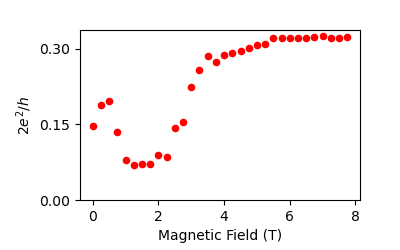

In [15]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math, os

#file path
fdir = r"C:\algos\jupyter-notebooks\data\2021-04-23_12nm Nb_5nm Au_10nm Te_pt contact"
fname = "2021-04-23_dIdV_vary H inplane persistent_-8T - 8T_0.25TdT_-1.7mV - 2.267mV_12nm Nb_5nmAu_300mK_smoothed_unnormalized_80uVdV.txt"

fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
print('Num data pts = {0}, Num Plots = {1}'.format(data.shape[0], data.shape[1] // 2))

#since individual plots may be offset along x-axis from each other, find a common x-interval to use for heat map
xlimits = (-.0015, .0015)
xscale = 1000 #to multiply the x-coordinates
yscale = 1 #to multiply the y-coordinates
dV = 80*10**-6
quantum_norm = True
single_x = False

params = np.linspace(-8, 8, num = 65)
#params = np.array([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 2, 2.4])

# choose parameter interval to plot
p_start = 20
p_end = 45

# include colorbar
yes_cbar = False

num_plots = data.shape[1] // 2
x = []
z = []

if not single_x:
    for i in range(num_plots):
        z.append(data[np.nonzero(np.logical_and(data[:,i*2] >= xlimits[0], data[:,i*2] <= xlimits[1])), i*2+1])
        x.append(data[np.nonzero(np.logical_and(data[:,i*2] >= xlimits[0], data[:,i*2] <= xlimits[1])), i*2])
    
    z = np.concatenate(z)
    x = xscale * np.concatenate(x)
else:
    for i in range(data.shape[1] - 1):
        z.append(data[:, i + 1])
        x.append(data[:, 0])
    
    z = np.vstack(z)
    x = xscale * np.vstack(x)
    


#repeat param_values array and then reshape to get the Y-coord grid, similar to what one would get from meshgrid
y = np.repeat(params, x.shape[1], axis = 0)
y = yscale * np.reshape(y, (len(params), x.shape[1]))

#normalize data
if quantum_norm:
    z = z / (dV * 7.7480917*10**-5)
else:
    for i in range(num_plots):
        z[i, :] *= 1 / np.average(data[0:5, i*2 + 1 if not single_x else i + 1])

slice_index = 76
print('X Coord = {}'.format(x[0, slice_index]))
        
fig, ax = plt.subplots(figsize = (4, 2.5))

ax.scatter(y[32:64, slice_index], z[32:64, slice_index], s= 20, color = 'red')

ax.set_ylabel(r'$2e^2/h$')
ax.set_xlabel('Magnetic Field (T)')

ax.set_xticks([0, 2, 4, 6, 8])
ax.set_yticks([0, .15, .3])


plt.subplots_adjust(left = 0.2 ,bottom = 0.2)    
plt.show()

plt.savefig('./plt_img/2021-04-23_dIdV ptcontact_5nmAu_12nm Nb_inplane_quantumnorm_0biasslice_dots.png', transparent = True)

# Curve fits to dIdV peaks in Intensity map

Num data pts = 101, Num Plots = 61
Parameter sliced = 1.0


<IPython.core.display.Javascript object>


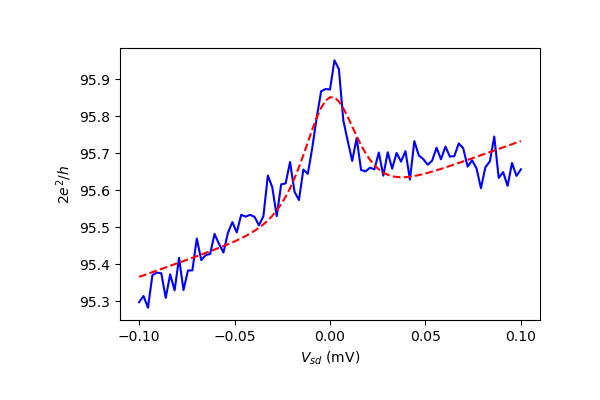

Fitting parameters
[95.54961117  1.83571425  1.20793471  0.1025006 ]


In [88]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math, os
from matplotlib.ticker import FormatStrFormatter

#file path
fdir = r"C:\algos\jupyter-notebooks\data\2022-02-15_EuS"
#fname = "2022-02-15_dIdV_vary H persis uniform_0.00T - 6.00T_101 steps_5E-6 Iscale_2.906E-4 Vscale_1 scans_sample1dev3_1nmTe_2.1uVdV_300mK_inplane.txt"
fname = "2022-02-15_dIdV_vary H persistent seq_-3T-3T_5E-6 Iscale_2.91E-4 Vscale_1 scans_sample1dev3_2.1uVdV_1.5K_inplanehysteresis.txt"

fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
print('Num data pts = {0}, Num Plots = {1}'.format(data.shape[0], data.shape[1] // 2))

data = data[:, 1:]

# Define constants
kb_meV = 8.617 * 10**-2 # Boltzmann constant in units of meV instead of eV

#since individual plots may be offset along x-axis from each other, find a common x-interval to use for heat map
xlimits = (-.0001, .0001)
xscale = 1000 #to multiply the x-coordinates
yscale = 1 #to multiply the y-coordinates
dV = 2.1*10**-6
quantum_norm = True
single_x = False

params = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 2.8, 2.6, 2.4, 2.2, 2.0, 1.8, 1.6, 1.4, 1.2, 1.0, 0.8, 0.6, 0.4, 0.2, -0.0, -0.2, -0.4, -0.6, -0.8, -1.0, -1.2, -1.4, -1.6, -1.8, -2.0, -2.2, -2.4, -2.6, -2.8, -3, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0]

num_plots = data.shape[1] // 2
x = []
z = []

if not single_x:
    for i in range(num_plots):
        z.append(data[np.nonzero(np.logical_and(data[:,i*2] >= xlimits[0], data[:,i*2] <= xlimits[1])), i*2+1])
        x.append(data[np.nonzero(np.logical_and(data[:,i*2] >= xlimits[0], data[:,i*2] <= xlimits[1])), i*2])
    
    z = np.concatenate(z)
    x = xscale * np.concatenate(x)
else:
    for i in range(data.shape[1] - 1):
        z.append(data[:, i + 1])
        x.append(data[:, 0])
    
    z = np.vstack(z)
    x = xscale * np.vstack(x)

#normalize data
if quantum_norm:
    z = z / (dV * 7.7480917*10**-5)
else:
    for i in range(num_plots):
        z[i, :] *= 1 / np.average(data[0:5, i*2 + 1 if not single_x else i + 1])


# Curve fitting starts here

# Multiple Gaussian fit. Provide parameters as one long list in the order:
# [offset, gaussian1 center, gaussian1 amplitude, gaussian1 stdev, gaussian2 center, gaussian2 amplitude, ...]
def multiple_gaussian(x, *params):
    y = np.zeros_like(x)
    for i in range(1, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y + params[0]

# Derivative of Fermi-Dirac distribution fit. Provide paramters as list: [offset, offset slope, amplitude, temperature]
def fermi_derivative(x, *params):
    return params[0] + params[1]*x + params[2]*np.exp(x / (kb_meV * params[3])) / np.square(np.exp(x / (kb_meV * params[3])) + 1)

# Pick a curve to fit to
slice_index = 5
x_window = [0, 90]
print('Parameter sliced = {}'.format(params[slice_index]))

parameter_guess = [96.2, 1.5, 0.3, .24]
        
fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(x[slice_index, x_window[0] : x_window[1]], z[slice_index, x_window[0] : x_window[1]], color = 'blue')

curve_fit, pcov = optimize.curve_fit(fermi_derivative, x[slice_index, x_window[0] : x_window[1]], 
                              z[slice_index, x_window[0] : x_window[1]], parameter_guess)

print('Fitting parameters')
print(curve_fit)

fitted_y = fermi_derivative(x[slice_index, x_window[0] : x_window[1]], *curve_fit)
ax.plot(x[slice_index, x_window[0] : x_window[1]], fitted_y, color = 'red', linestyle = '--')

ax.set_ylabel(r'$2e^2/h$')
ax.set_xlabel(r'$V_{sd}$ (mV)')

ax.set_xticks([-.1, -.05, 0, .05, .1])


plt.subplots_adjust(left = 0.2 ,bottom = 0.2)    
plt.show()

#plt.savefig('./plt_img/2022-02-15_dIdV_1T_240mK_fermiderivativefit.png', transparent = True)

In [41]:
import numpy as np

x = np.linspace(-1, 1, 11)

y = np.array([x, x]).T.reshape(-1, 1, 2)

print(y.shape)

print(y[:-1])

segments = np.concatenate([y[:-1], y[1:]], axis=1)



print(segments.shape)

(11, 1, 2)
[[[-1.  -1. ]]

 [[-0.8 -0.8]]

 [[-0.6 -0.6]]

 [[-0.4 -0.4]]

 [[-0.2 -0.2]]

 [[ 0.   0. ]]

 [[ 0.2  0.2]]

 [[ 0.4  0.4]]

 [[ 0.6  0.6]]

 [[ 0.8  0.8]]]
(10, 2, 2)


# General Plotting

(67, 2)


<IPython.core.display.Javascript object>


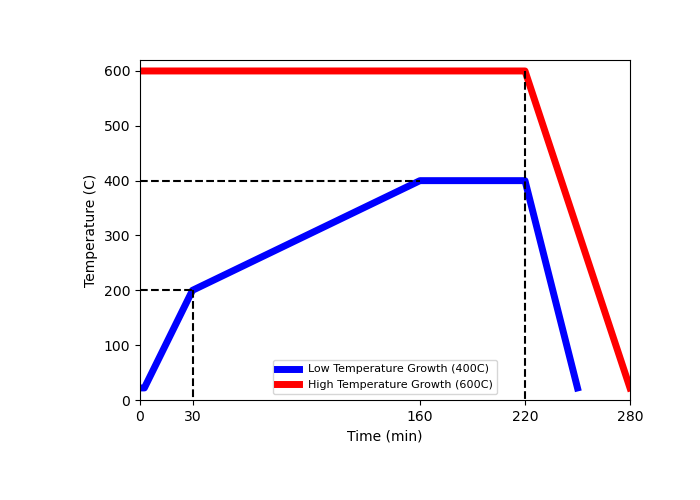

In [21]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math, os

#single file path
fdir = r"C:\algos\jupyter-notebooks\data\2021-02-17_8nm Nb_15nm Au_7nm Te_pt contact\Sheet R vs T"
fname = "2021-02-17_sheet R v T_15nm Au_0T outplane.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
print(data.shape)

fig, ax = plt.subplots(figsize = (7,5))
#ax.tick_params(axis = 'both', which = 'both', bottom = False, left = True, labelleft = True, labelbottom = False)


ax.plot([0, 2.5, 30, 160, 220, 250], [22, 22, 200, 400, 400, 22], color = 'blue', linewidth = 5)
ax.plot([0, 220, 280], [600, 600, 22], color = 'red', linewidth = 5)

ax.plot([0,160],[400, 400], color = 'black', linestyle = '--')
ax.plot([30, 30],[200, 0],color='black',linestyle = '--')

ax.plot([220, 220],[600, 0],color='black',linestyle = '--')
ax.plot([0,30],[200, 200], color = 'black', linestyle = '--')

ax.set_xlabel('Time (min)')
ax.set_ylabel('Temperature (C)')

ax.set_xticks([0, 30, 160, 220, 280])
ax.set_xlim([0, 280])
ax.set_ylim([0, 620])

plt.legend(['Low Temperature Growth (400C)', 'High Temperature Growth (600C)'], 
           prop={'size': 8, 'stretch': 'semi-expanded'})

plt.subplots_adjust(left = 0.2 ,bottom = 0.2) 
plt.show()

#plt.savefig('./plt_img/nbse2growthprofile.png', transparent = True)

<IPython.core.display.Javascript object>


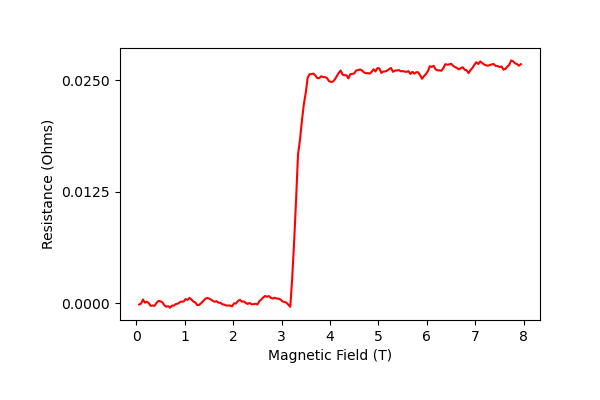

In [11]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math, os

#single file path
fdir = r"C:\algos\jupyter-notebooks\data\2021-10-21_8nmNb_10nmAu_9nmTe_ptcontact"
fname = "2021-10-21_R vs H_7.1517uA_10nmAu_9nmTe_300mK_4terminal.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

data = np.genfromtxt(fpath, delimiter="\t", dtype=float)

fig, ax = plt.subplots(figsize = (6,4))
#ax.tick_params(axis = 'both', which = 'both', bottom = False, left = True, labelleft = True, labelbottom = False)


ax.plot(data[:,0], data[:, 1], color = 'red')

ax.set_yticks(np.linspace(0, .025, num = 3))
ax.set_ylabel('Resistance (Ohms)')
ax.set_xlabel('Magnetic Field (T)')

plt.subplots_adjust(left = 0.2, bottom = 0.2) 
plt.show()

plt.savefig('./plt_img/20211021RH.png', transparent = True)